Import and classes

In [2]:
import os
import nibabel as nib
import numpy as np
import torch
import monai
from monai.transforms import (
    Compose, LoadImageD, EnsureChannelFirstD, ScaleIntensityRangeD, SpacingD, ToTensorD
)
from monai.data import Dataset, DataLoader, MetaTensor
from monai.inferers import SlidingWindowInferer
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import SimpleITK as sitk
from IPython.display import display, clear_output
import torch.nn.functional as F
from monai.transforms import Transform
from tqdm import tqdm
import glob

C:\Users\gijsd\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [3]:

from skimage import exposure
#imopr

class HistogramEqualization(Transform):
    def __call__(self, sample):
        image = sample['image']

        if isinstance(image, MetaTensor):
            image_data = image.as_tensor()
            image_meta_dict = image.meta
            equalized_image = exposure.equalize_hist(image_data.numpy())  # Normalizes to [0, 1]
            equalized_image = MetaTensor(equalized_image * 255, meta=image_meta_dict)
        else:
            equalized_image = exposure.equalize_hist(image)
            equalized_image = equalized_image * 255
        sample['image'] = equalized_image
        return sample

class ConvertToFloat32:
    def __call__(self, sample):
        sample['image'] = sample['image'].astype(np.float32)
        #sample['label'] = sample['label'].astype(np.float32)
        return sample

from monai.data import MetaTensor

class LoadData(Transform):
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        image = sample['image']
        #mask = sample['label']

        #image_meta_dict = sample['image_meta_dict']
        #mask_meta_dict = sample['mask_meta_dict']

        # Convert image and mask to MetaTensor with associated metadata
        image = MetaTensor(image, affine=sample['affine'])
        #mask = MetaTensor(mask, affine=mask_meta_dict['affine'])

        #return {'image': image, 'label': mask, 'image_meta_dict': image_meta_dict, 'mask_meta_dict': mask_meta_dict}
        return {'image': image, 'affine': sample['affine']}

Choose network here and load it:

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

# Load the model
# Fifth run
# model = monai.networks.nets.UNet(
#     spatial_dims=2,
#     in_channels=1,
#     out_channels=4,
#     channels=(16, 32, 64, 128),
#     strides=(2, 2, 2),
#     num_res_units=2,
#     kernel_size=5,
#     up_kernel_size=5,
#     dropout=0.2
# ).to(device)
# 
# # model.load_state_dict(torch.load('../model_saves/trainedUNet_Fifth_Run_best_val_loss.pt'))
# model.load_state_dict(torch.load('../model_saves/trainedUNet_Fifth_Run_checkpoint_55.pt'))

#Sixth run:
# model = monai.networks.nets.UNet( #default kernel size is 3
#     spatial_dims=2,
#     in_channels=1,
#     out_channels=4,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
#     kernel_size=5,
#     up_kernel_size=5,
#     dropout=0.2
# ).to(device)
# 
# model.load_state_dict(torch.load('../model_saves/trainedUNet_Sixth_Run_checkpoint_30.pt'))

#best swin
model = monai.networks.nets.SwinUNETR(
    img_size=(256, 256),
    in_channels=1,
    out_channels=4,
    feature_size=48,
    spatial_dims=2,
    #use_checkpoint = True,
    use_v2=True
).to(device)

# model.load_state_dict(torch.load('../model_saves/best_swin/trainedSwinUNetrv2Sixth_Run_final.pt'), map_location=device)

checkpoint_path = '../model_saves/best_swin/trainedSwinUNetrv2Sixth_Run_final.pt'
checkpoint= torch.load(checkpoint_path, map_location=device)
# print(checkpoint.keys())
model.load_state_dict(checkpoint)
model.eval()

The used device is cuda
odict_keys(['swinViT.patch_embed.proj.weight', 'swinViT.patch_embed.proj.bias', 'swinViT.layers1.0.blocks.0.norm1.weight', 'swinViT.layers1.0.blocks.0.norm1.bias', 'swinViT.layers1.0.blocks.0.attn.relative_position_bias_table', 'swinViT.layers1.0.blocks.0.attn.relative_position_index', 'swinViT.layers1.0.blocks.0.attn.qkv.weight', 'swinViT.layers1.0.blocks.0.attn.qkv.bias', 'swinViT.layers1.0.blocks.0.attn.proj.weight', 'swinViT.layers1.0.blocks.0.attn.proj.bias', 'swinViT.layers1.0.blocks.0.norm2.weight', 'swinViT.layers1.0.blocks.0.norm2.bias', 'swinViT.layers1.0.blocks.0.mlp.linear1.weight', 'swinViT.layers1.0.blocks.0.mlp.linear1.bias', 'swinViT.layers1.0.blocks.0.mlp.linear2.weight', 'swinViT.layers1.0.blocks.0.mlp.linear2.bias', 'swinViT.layers1.0.blocks.1.norm1.weight', 'swinViT.layers1.0.blocks.1.norm1.bias', 'swinViT.layers1.0.blocks.1.attn.relative_position_bias_table', 'swinViT.layers1.0.blocks.1.attn.relative_position_index', 'swinViT.layers1.0.block

RuntimeError: Error(s) in loading state_dict for SwinUNETR:
	size mismatch for swinViT.layers1c.0.layer.conv1.conv.weight: copying a param with shape torch.Size([48, 48, 3, 3]) from checkpoint, the shape in current model is torch.Size([48, 48, 3, 3, 3]).
	size mismatch for swinViT.layers1c.0.layer.conv2.conv.weight: copying a param with shape torch.Size([48, 48, 3, 3]) from checkpoint, the shape in current model is torch.Size([48, 48, 3, 3, 3]).
	size mismatch for swinViT.layers2c.0.layer.conv1.conv.weight: copying a param with shape torch.Size([96, 96, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 96, 3, 3, 3]).
	size mismatch for swinViT.layers2c.0.layer.conv2.conv.weight: copying a param with shape torch.Size([96, 96, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 96, 3, 3, 3]).
	size mismatch for swinViT.layers3c.0.layer.conv1.conv.weight: copying a param with shape torch.Size([192, 192, 3, 3]) from checkpoint, the shape in current model is torch.Size([192, 192, 3, 3, 3]).
	size mismatch for swinViT.layers3c.0.layer.conv2.conv.weight: copying a param with shape torch.Size([192, 192, 3, 3]) from checkpoint, the shape in current model is torch.Size([192, 192, 3, 3, 3]).
	size mismatch for swinViT.layers4c.0.layer.conv1.conv.weight: copying a param with shape torch.Size([384, 384, 3, 3]) from checkpoint, the shape in current model is torch.Size([384, 384, 3, 3, 3]).
	size mismatch for swinViT.layers4c.0.layer.conv2.conv.weight: copying a param with shape torch.Size([384, 384, 3, 3]) from checkpoint, the shape in current model is torch.Size([384, 384, 3, 3, 3]).

Function to perform inference on a 4D image and save the result as a .nii.gz file, has options to show and save the result

In [6]:
# Define preprocessing transformations
pixdim_x = 0.9
pixdim_y = 0.9
size_x = 256
size_y = 256

preprocess_transform_secret = monai.transforms.Compose([
    LoadData(keys=['image']),
    HistogramEqualization(),
    monai.transforms.ScaleIntensityd(keys=['image'], minv=0.0, maxv=1.0),
    #monai.transforms.SpacingD(keys=['image'], pixdim=(pixdim_x, pixdim_y, None), mode=['bilinear']),
    ConvertToFloat32(),
    monai.transforms.ToTensorD(keys=['image'])
])

# Function to perform inference on a 4D image and save the result as a .nii.gz file
def segment_4d_image(image_path, model, preprocess, output_path, to_show=True, to_save=False):
    # Load the 4D image
    img = nib.load(image_path)
    img_data = img.get_fdata()

    # get voxel spacing
    img_spacing_x = img.header['pixdim'][1]
    img_spacing_y = img.header['pixdim'][2]
    
    slice_affine = np.array([[-img_spacing_x, 0, 0], [0, img_spacing_y, 0], [0, 0, 1]])
    
    # Prepare to store the segmentation results
    seg_data = np.zeros(img_data.shape, dtype=np.uint8)
    
    # slice_affine = img.affine[:2, :2]
    # slice_affine = np.pad(slice_affine, ((0, 1), (0, 1)), mode='constant')
    # slice_affine[-1, -1] = 1
    # print(slice_affine)

    # Iterate over the time dimension
    for t in range(img_data.shape[3]):
        time_slice = img_data[..., t]

        # Iterate over the depth dimension
        for z in range(time_slice.shape[2]):
            slice_2d = time_slice[:, :, z]
            slice_shape = slice_2d.shape
            slice_2d = np.expand_dims(slice_2d, axis=0)

            # Preprocess the slice
            slice_dict = {'image': slice_2d, 'affine': slice_affine}          
            slice_dict = preprocess(slice_dict)
            input_tensor = slice_dict['image'].to(device)        
            
            # Perform inference
            with torch.no_grad():
                inferer = SlidingWindowInferer(roi_size=(size_x, size_y))
                output = inferer(input_tensor.unsqueeze(0), network=model)
                output = torch.argmax(output, dim=1).cpu().numpy()
           
            if to_show:
                # Plot the original and segmented images
                plt.imshow(input_tensor[0].cpu(), cmap='gray')
                plt.imshow(output[0], cmap=ListedColormap(['none', 'red', 'green', 'blue']) , alpha=0.5)
                plt.title('Segmented image, slice ' + str(z) + ', time ' + str(t))
                clear_output(wait=True)
                plt.show()

            #resize the output back to slice_shape (208, 256) using nearest neigbhbour interpolation using numpy
            output = output[0]
            output = F.interpolate(torch.tensor(output).unsqueeze(0).unsqueeze(0).float(), size=slice_shape, mode='nearest').squeeze().numpy()
            
            # Store the segmentation result
            seg_data[:, :, z, t] = output

    if to_save:
        # Save the segmentation result as a .nii.gz file
        seg_img = nib.Nifti1Image(seg_data, img.affine, img.header)
        nib.save(seg_img, output_path)
    
    if to_show:
        print(f"Segmentation saved to {output_path}")

secret_test_folder_path = '../data/secret_test/'
output_folder_secret = '../data_predictions/secret_test_predictions/'

Small code block for testing the function on a single patient

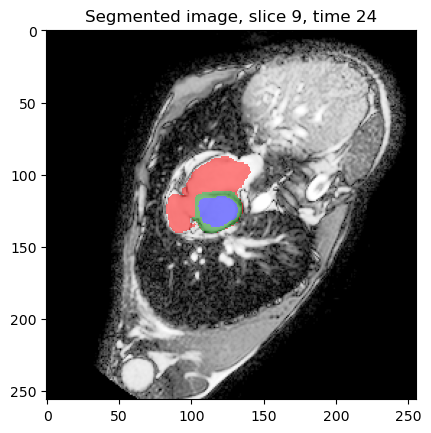

Segmentation saved to ../data_predictions/secret_test_predictions/patient175_frame01_seg.nii.gz


In [5]:
# SKIP

patient = 'patient175' #  'patient'  + number (from 001 to 175)
image_path = secret_test_folder_path + patient +'/' + patient + '_frame01.nii.gz'
output_path = output_folder_secret + patient + '_frame01_seg.nii.gz'

# #try training image for comparison
# image_path = '../data/testing/patient101/patient101_4d.nii.gz'
# output_path = '../data_predictions/_test_patient011_4d_seg.nii.gz'
segment_4d_image(image_path, model, preprocess_transform_secret, output_path)

Getting predictions for all secret test patients and saving them

In [5]:
# SKIP

# repeat for all secret test patients 151 to 175
for i in tqdm(range(151, 176), desc='Segmenting secret test patients'):
    patient = 'patient' + str(i).zfill(3)
    image_path = secret_test_folder_path + patient +'/' + patient + '_frame01.nii.gz'
    output_path = output_folder_secret + patient + '_frame01_seg.nii.gz'
    segment_4d_image(image_path, model, preprocess_transform_secret, output_path, to_show=False, to_save=True)

Segmenting secret test patients: 100%|██████████| 25/25 [01:19<00:00,  3.17s/it]


The same function as above but for 3D images for testing and training data

In [7]:
def segment_3d_image(image_path, model, preprocess, output_path, to_show=True, to_save=False):
    # Load the 3D image
    img = nib.load(image_path)
    img_data = img.get_fdata()

    # get voxel spacing
    img_spacing_x = img.header['pixdim'][1]
    img_spacing_y = img.header['pixdim'][2]

    slice_affine = np.array([[-img_spacing_x, 0, 0], [0, img_spacing_y, 0], [0, 0, 1]])

    # Prepare to store the segmentation results
    seg_data = np.zeros(img_data.shape, dtype=np.uint8)

    # slice_affine = img.affine[:2, :2]
    # slice_affine = np.pad(slice_affine, ((0, 1), (0, 1)), mode='constant')
    # slice_affine[-1, -1] = 1
    # print(slice_affine)

    # Iterate over the depth dimension
    for z in range(img_data.shape[2]):
        slice_2d = img_data[:, :, z]
        slice_shape = slice_2d.shape
        slice_2d = np.expand_dims(slice_2d, axis=0)

        # Preprocess the slice
        slice_dict = {'image': slice_2d, 'affine': slice_affine}
        slice_dict = preprocess(slice_dict)
        input_tensor = slice_dict['image'].to(device)

        # Perform inference
        with torch.no_grad():
            inferer = SlidingWindowInferer(roi_size=(size_x, size_y))
            output = inferer(input_tensor.unsqueeze(0), network=model)
            output = torch.argmax(output, dim=1).cpu().numpy()

        if to_show:
            # Plot the original and segmented images
            plt.imshow(input_tensor[0].cpu(), cmap='gray')
            plt.imshow(output[0], cmap=ListedColormap(['none', 'red', 'green', 'blue']) , alpha=0.5)
            plt.title('Segmented image, slice ' + str(z))
            clear_output(wait=True)
            plt.show()

        #resize the output back to slice_shape (208, 256) using nearest neigbhbour interpolation using numpy
        output = output[0]
        output = F.interpolate(torch.tensor(output).unsqueeze(0).unsqueeze(0).float(), size=slice_shape, mode='nearest').squeeze().numpy()

        # Store the segmentation result
        seg_data[:, :, z] = output

    if to_save:
        # Save the segmentation result as a .nii.gz file
        seg_img = nib.Nifti1Image(seg_data, img.affine, img.header)
        nib.save(seg_img, output_path)

    if to_show:
        print(f"Segmentation saved to {output_path}")

test_folder_path = '../data/testing/'
output_folder_test = '../data_predictions/testing_predictions/'
output_folder_train = '../data_predictions/training_predictions/'

# patient = 'patient101' #  'patient'  + number (from 001 to 175)
# image_path = test_folder_path + patient +'/' + patient + '_frame01.nii.gz'
# output_path = output_folder_test + patient + '_frame01_seg.nii.gz'
# segment_3d_image(image_path, model, preprocess_transform_secret, output_path)

Gathering predictions for all testing and training images

In [8]:
testing_path = '../data/testing/'
training_path = '../data/training/'

def get_acdc_file_paths(data_path):
    original_images = glob.glob(os.path.join(data_path, 'patient*/patient*_frame??.nii.gz'))
    return original_images

training_image_paths = get_acdc_file_paths(training_path)
testing_image_paths = get_acdc_file_paths(testing_path)


In [9]:
# get predictions for testing images
print(testing_image_paths[0]) #= ../data/testing\patient101\patient101_frame01.nii.gz
for image_path in tqdm(testing_image_paths, desc='Segmenting testing images'):
    patient_no = image_path.split('_')[-2][-3:]
    frame_no = image_path.split('_')[-1].split('.')[0][-2:]
    output_path = output_folder_test + 'patient'+ patient_no +'_' + 'frame' + frame_no + '_seg.nii.gz'
    segment_3d_image(image_path, model, preprocess_transform_secret, output_path, to_show=False, to_save=True)

../data/testing\patient101\patient101_frame01.nii.gz


Segmenting testing images:   0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [48, 48, 3, 3, 3], expected input[1, 1, 48, 128, 128] to have 48 channels, but got 1 channels instead

In [9]:
# SKIP

# get predictions for training images
for image_path in tqdm(training_image_paths, desc='Segmenting training images'):
    patient_no = image_path.split('_')[-2][-3:]
    frame_no = image_path.split('_')[-1].split('.')[0][-2:]
    output_path = output_folder_train + 'patient'+ patient_no +'_' + 'frame' + frame_no + '_seg.nii.gz'
    segment_3d_image(image_path, model, preprocess_transform_secret, output_path, to_show=False, to_save=True)


Segmenting training images: 100%|██████████| 200/200 [00:14<00:00, 13.64it/s]


In [20]:
# Get evaluation metrics for the testing set, mean dice for each class and mean hausdorff distance for each class
# For this we load the ground truth and the predictions .nii.gz and calculate the metrics

#folder that contains all predictions
predictions_folder = '../data_predictions/testing_predictions/'

#folder that contains all ground truth
ground_truth_folder = '../data/testing/'

#function to calculate dice and hausdorff distance
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from scipy.ndimage import zoom

def show_sample_plot(prediction,ground_truth):
    label_cmap = ListedColormap(['none', 'red', 'green', 'blue'])
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(prediction[0, :, :, 4], cmap=label_cmap)
    plt.title('Prediction')
    plt.subplot(1, 2, 2)
    plt.imshow(ground_truth[0, :, :, 4], cmap=label_cmap)
    plt.title('Ground Truth')
    plt.show()

def resample_to_isotropic(image, new_spacing=(1.0, 1.0, 10)):
    old_spacing = image.header.get_zooms()[:3]
    resample_factor = [os/ns for os, ns in zip(old_spacing, new_spacing)]
    resampled_image = zoom(image.get_fdata(), resample_factor, order=1)
    new_affine = np.copy(image.affine)
    new_affine[:3, :3] = np.diag(new_spacing)
    return nib.Nifti1Image(resampled_image, new_affine)

def calculate_metrics(predictions_folder, ground_truth_folder, subset=None):
    # Get all predictions and ground truth paths
    predictions = [f for f in os.listdir(predictions_folder) if f.endswith('.nii.gz')]
    ground_truth = get_acdc_file_paths(ground_truth_folder)
    
    dice_metric = DiceMetric(include_background=True, reduction="mean_channel", num_classes=4)# ignore_empty=True)
    hausdorff_metric = HausdorffDistanceMetric(include_background=True, reduction="none", percentile=95)

    # Initialize lists to store the metrics
    dice_scores = torch.tensor([])
    hausdorff_distances = torch.tensor([])

    # Iterate over all predictions and ground truth
    for i in tqdm(range(len(predictions)), desc='Calculating metrics'):
        if subset == "ES":
            if 'frame01' in predictions[i]:
                continue
        elif subset == "ED":
            if 'frame01' not in predictions[i]:
                continue
        
        # Load predictions and ground truth
        prediction_path = os.path.join(predictions_folder, predictions[i])
        gt_path = ground_truth[i]

        prediction = nib.load(prediction_path).get_fdata()
        gt = nib.load(gt_path.replace('.nii.gz', '_gt.nii.gz')).get_fdata()

        # Resample both prediction and ground truth to isotropic spacing
        #prediction = resample_to_isotropic(prediction).get_fdata()
        #gt = resample_to_isotropic(gt).get_fdata()

        # Check if the patient and frame number match
        assert predictions[i].split('_')[0] == ground_truth[i].split('\\')[-1].split('_')[0]
        assert predictions[i].split('_')[1] == ground_truth[i].split('\\')[-1].split('_')[1].split('.')[0]

        #print(f'Patient: {predictions[i].split("_")[0]}, Frame: {predictions[i].split("_")[1].split(".")[0]}')

        #convet to pytorch tensor
        prediction_tensor = torch.tensor(prediction)
        gt_tensor = torch.tensor(gt)
        
        #add channel dimensin
        prediction_tensor = prediction_tensor.unsqueeze(0).unsqueeze(0) #NEEDS BATCH DIMENSION!!!!!!!!!!!
        gt_tensor = gt_tensor.unsqueeze(0).unsqueeze(0)  #current shape: (1, 1, 208, 256, 10)
        
        #show_sample_plot(prediction_tensor,gt_tensor)
        
        # Calculate dice
        dice_metric(y_pred=prediction_tensor, y=gt_tensor)
        
        #hausdorf likes one hot binary tensors
        pred_one_hot = torch.nn.functional.one_hot(prediction_tensor.squeeze().long(), num_classes=4).permute(3,0,1,2).float().unsqueeze(0)
        gt_one_hot = torch.nn.functional.one_hot(gt_tensor.squeeze().long(), num_classes=4).permute(3,0,1,2).float().unsqueeze(0)
        
        #print(pred_one_hot.shape,gt_one_hot.shape)
        hausdorff_metric(y_pred=pred_one_hot, y=gt_one_hot)

        # Finalize dice metric computation
        dice_score = dice_metric.aggregate(reduction="none")
        #print(dice_score) #has 4 values
        dice_scores = torch.cat((dice_scores, dice_score))
        dice_metric.reset()
    
        # Finalize hausdorff metric computation
        hausdorff_distance = hausdorff_metric.aggregate(reduction="none")
        hausdorff_distances = torch.cat((hausdorff_distances, hausdorff_distance))
        hausdorff_metric.reset()

    mean_dsc_per_class = dice_scores.mean(dim=0)
    mean_hd_per_class = hausdorff_distances.mean(dim=0)

    return mean_dsc_per_class, mean_hd_per_class

class_names = ['background', 'RV', 'MY', 'LV']

dsc, hd = calculate_metrics(predictions_folder, ground_truth_folder)

print(f'AVG DSC: {dsc.mean()}', f'AVG HD: {hd.mean()}')
print(f"Whole set- Mean Dice Score: {dsc}")
print(f"Whole set- Mean Hausdorff Distance: {hd}")

dsc, hd = calculate_metrics(predictions_folder, ground_truth_folder, subset="ES")
print(f"Mean Dice Score ES: {dsc}")
print(f"Mean Hausdorff Distance ES: {hd}")

dsc, hd = calculate_metrics(predictions_folder, ground_truth_folder, subset="ED")
print(f"Mean Dice Score ED: {dsc}")
print(f"Mean Hausdorff Distance ED: {hd}")


Calculating metrics: 100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


AVG DSC: 0.864028811454773 AVG HD: 13.066312789916992
Whole set- Mean Dice Score: tensor([0.9951, 0.7626, 0.8311, 0.8673])
Whole set- Mean Hausdorff Distance: tensor([ 0.3241, 20.2519, 14.0580, 17.6312])


Calculating metrics: 100%|██████████| 100/100 [00:07<00:00, 12.93it/s]


Mean Dice Score ES: tensor([0.9939, 0.6639, 0.8261, 0.8032])
Mean Hausdorff Distance ES: tensor([ 0.4283, 22.8006, 16.0702, 21.0590])


Calculating metrics: 100%|██████████| 100/100 [00:07<00:00, 12.58it/s]

Mean Dice Score ED: tensor([0.9963, 0.8613, 0.8362, 0.9314])
Mean Hausdorff Distance ED: tensor([ 0.2200, 17.7031, 12.0459, 14.2034])
